# Sentiment Analysis of Amazon Reviews


In [3]:
import pandas as pd
import numpy as np

In [4]:
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [5]:
#read the csv
amazon_reviews = pd.read_csv('/content/drive/My Drive/Amazon-Dataset/1429_1.csv')
amazon_reviews.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


In [6]:
amazon_reviews.isnull().values.any()

True

In [7]:
amazon_reviews.shape

(34660, 21)

In [9]:
review=pd.DataFrame(amazon_reviews.groupby('reviews.rating').size().sort_values(ascending=False).rename('No of Users').reset_index())
review.head()

,reviews.rating,No of Users
0,5.0,23775
1,4.0,8541
2,3.0,1499
3,1.0,410
4,2.0,402


In [10]:
data1 = amazon_reviews[['reviews.rating', 'reviews.text' ]]
final = data1.dropna()
final.head()

,reviews.rating,reviews.text
0,5.0,This product so far has not disappointed. My c...
1,5.0,great for beginner or experienced person. Boug...
2,5.0,Inexpensive tablet for him to use and learn on...
3,4.0,I've had my Fire HD 8 two weeks now and I love...
4,5.0,I bought this for my grand daughter when she c...


In [11]:
labels = final['reviews.rating']
data = final['reviews.text']
labels = np.array(list(map(lambda x: 1 if x>=float(4) else 0, labels)))
print(data)
print(labels)

0        This product so far has not disappointed. My c...
1        great for beginner or experienced person. Boug...
2        Inexpensive tablet for him to use and learn on...
3        I've had my Fire HD 8 two weeks now and I love...
4        I bought this for my grand daughter when she c...
                               ...                        
34655    This is not appreciably faster than any other ...
34656    Amazon should include this charger with the Ki...
34657    Love my Kindle Fire but I am really disappoint...
34658    I was surprised to find it did not come with a...
34659    to spite the fact that i have nothing but good...
Name: reviews.text, Length: 34626, dtype: object
[1 1 1 ... 0 0 0]


In [12]:
from sklearn.utils import shuffle

def prepare_amazon_data(data, labels):
    """Prepare training and test sets from Amazon reviews."""    
    # Create Partation
    data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.20)

    #Shuffle reviews and corresponding labels within training and test sets
    data_train, labels_train = shuffle(data_train, labels_train)
    data_test, labels_test = shuffle(data_test, labels_test)
    
    # Return a unified training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test

In [13]:
train_X, test_X, train_y, test_y = prepare_amazon_data(data,labels)
print("Amazon reviews (combined): train = {}, test = {}".format(len(train_X), len(test_X)))

Amazon reviews (combined): train = 27700, test = 6926


In [14]:
print(len([1 for i in train_y if i==1]))
print(len([1 for i in test_y if i==1]))
print(len([1 for i in train_y if i==0]))
print(len([1 for i in test_y if i==0]))

25851
6464
1849
462


In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from string import punctuation
import re
from bs4 import BeautifulSoup

def review_to_words(review):
    nltk.download("stopwords", quiet=True)
    stemmer = PorterStemmer()
    
    text = BeautifulSoup(review, "html.parser").get_text() # Remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    words = [w for w in words if w not in punctuation]
    words = [PorterStemmer().stem(w) for w in words] # stem
    
    return words

In [16]:
def preprocess_data(data_train, data_test):
  words_train = [review_to_words(review) for review in data_train]
  words_test = [review_to_words(review) for review in data_test]

  return words_train, words_test

In [17]:
train_X, test_X = preprocess_data(train_X, test_X)

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://www.amazon.com/dp/B01J2G4VBG/refcmcrrypprdttlsol4" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [18]:
import os
import pickle
cache_dir = os.path.join("/content/drive/My Drive/Amazon-Dataset/cache", "sentiment_analysis")
cache_file="preprocessed_amazon_review_data.pkl"

os.makedirs(cache_dir, exist_ok=True)

cache_data = dict(words_train=train_X, words_test=test_X,
                  labels_train=train_y, labels_test=test_y)
with open(os.path.join(cache_dir, cache_file), "wb") as f:
    pickle.dump(cache_data, f)
print("Wrote preprocessed data to cache file:", cache_file)

Wrote preprocessed data to cache file: preprocessed_amazon_review_data.pkl


In [19]:
import numpy as np

def build_vocab(data, vocab_size= 5000):
  word_count = {}
  for sentence in data:
    for word in sentence:
      if word in word_count:
        word_count[word] += 1
      else:
        word_count[word] = 1

  sorted_words = [key for key, value in sorted(word_count.items(), key=lambda word:word[1], reverse=True)]

  word_dict ={}

  for idx, word in enumerate(sorted_words[:vocab_size-2]):
    word_dict[word] = idx + 2
  
  return word_dict

In [20]:
word_dict = build_vocab(train_X)

In [23]:
def convert_and_pad(word_dict, sentence, pad=300):
    NOWORD = 0 # We will use 0 to represent the 'no word' category
    INFREQ = 1 # and we use 1 to represent the infrequent words, i.e., words not appearing in word_dict
    
    working_sentence = [NOWORD] * pad
    
    for word_index, word in enumerate(sentence[:pad]):
        if word in word_dict:
            working_sentence[word_index] = word_dict[word]
        else:
            working_sentence[word_index] = INFREQ
            
    return working_sentence, min(len(sentence), pad)

def convert_and_pad_data(word_dict, data, pad=300):
    result = []
    lengths = []
    
    for sentence in data:
        converted, leng = convert_and_pad(word_dict, sentence, pad)
        result.append(converted)
        lengths.append(leng)
        
    return np.array(result), np.array(lengths)

In [24]:
train_X, train_X_len = convert_and_pad_data(word_dict, train_X)
test_X, test_X_len = convert_and_pad_data(word_dict, test_X)

In [25]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.42B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [26]:
vocab_size = 5000
embedding_matrix = zeros((vocab_size, 300))
for word, index in word_dict.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [27]:
import tensorflow as tf

model = tf.keras.models.Sequential([ tf.keras.layers.Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(1024, activation='relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.Dense(124, activation='relu'),
                                    tf.keras.layers.Dense(1, activation='sigmoid')])


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          1500000   
_________________________________________________________________
flatten (Flatten)            (None, 90000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 90000)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              92161024  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 124)               6

In [29]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

In [30]:
history = model.fit(train_X, train_y, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
174/174 [==============================] - 20s 114ms/step - loss: 0.2503 - acc: 0.9305 - val_loss: 0.2295 - val_acc: 0.9329
Epoch 2/10
174/174 [==============================] - 20s 113ms/step - loss: 0.2068 - acc: 0.9351 - val_loss: 0.2843 - val_acc: 0.9330
Epoch 3/10
174/174 [==============================] - 20s 113ms/step - loss: 0.1847 - acc: 0.9415 - val_loss: 0.3171 - val_acc: 0.9332
Epoch 4/10
174/174 [==============================] - 20s 113ms/step - loss: 0.1593 - acc: 0.9487 - val_loss: 0.3003 - val_acc: 0.9336
Epoch 5/10
174/174 [==============================] - 20s 113ms/step - loss: 0.1432 - acc: 0.9553 - val_loss: 0.3264 - val_acc: 0.9339
Epoch 6/10
174/174 [==============================] - 20s 114ms/step - loss: 0.1270 - acc: 0.9598 - val_loss: 0.5989 - val_acc: 0.9338
Epoch 7/10
174/174 [==============================] - 20s 113ms/step - loss: 0.1100 - acc: 0.9644 - val_loss: 0.3681 - val_acc: 0.9323
Epoch 8/10
174/174 [==============================] - 2

In [31]:
score = model.evaluate(test_X, test_y, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

217/217 [==============================] - 3s 12ms/step - loss: 0.5294 - acc: 0.9337
Test Score: 0.5293750166893005
Test Accuracy: 0.9337279796600342


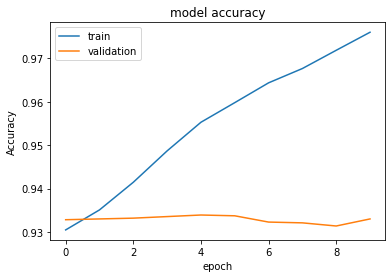

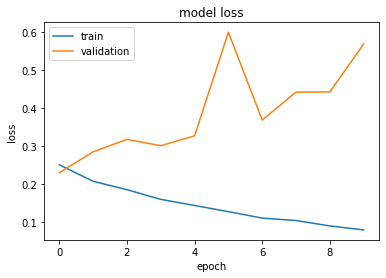

In [32]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [33]:
def predict(text):
    words = review_to_words(text)
    text, len = convert_and_pad_data(word_dict,words, 300)
    if (model.predict(text)>0.5).astype("int32")[0][0]:
      return "Positive"
    else:
      return "Negative"

In [34]:
text = input("Enter Review:")
print(predict(text))

Enter Review:this is very good product and very nice design
Positive
